# Preguntas de Negocio - PAGOS Y TRANSACCIONES

Este notebook responde las siguientes preguntas de negocio relacionadas con pagos y transacciones:
1. ¿Cuáles son los métodos de pago más utilizados?
2. ¿Cuál es el monto promedio pagado por método de pago?
3. ¿Cuántas órdenes se pagaron usando más de un método de pago?
4. ¿Cuántos pagos están en estado 'Procesando' o 'Fallido'?
5. ¿Cuál es el monto total recaudado por mes?


## Configuración Inicial e Importaciones


In [9]:
# Importar bibliotecas necesarias
import sys
import os

# Configurar el path para importar módulos del proyecto
current_dir = os.getcwd()
project_root = os.path.dirname(current_dir) if 'preguntas_negocio' in current_dir else current_dir

# Agregar el directorio raíz al path
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Importar DBConnector
try:
    from database.db_connector import DBConnector
except ImportError:
    # Intentar con mayúscula (compatibilidad con notebooks existentes)
    from Database.db_connector import DBConnector

# Importar bibliotecas de análisis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

print("✓ Bibliotecas importadas correctamente")


✓ Bibliotecas importadas correctamente


In [10]:
# Obtener el Engine de la base de datos usando DBConnector (patrón Singleton)
db = DBConnector.get_instance()
engine = db.get_engine()

print("✓ Conexión a la base de datos establecida")
print(f"✓ Engine obtenido: {type(engine).__name__}")


✓ Conexión a la base de datos establecida
✓ Engine obtenido: Engine


## 1. ¿Cuáles son los métodos de pago más utilizados?


MÉTODOS DE PAGO MÁS UTILIZADOS
 metodo_pago_id                         metodo_pago                                                         descripcion  total_uso  total_ordenes  monto_total
              7                            Efectivo      Pago en efectivo contra entrega o en punto de pago habilitado.       1493           1493    809547.11
              4                   Tarjeta de débito              Pago con tarjeta de débito asociada a cuenta bancaria.       1458           1458    810915.91
              5              Transferencia bancaria                    Transferencia desde cuenta bancaria del cliente.       1434           1434    791496.47
              3 Tarjeta de crédito American Express                       Pago con tarjeta de crédito American Express.       1428           1428    795988.89
              6      Billetera virtual Mercado Pago                            Pago procesado a través de Mercado Pago.       1421           1421    792336.04
              2

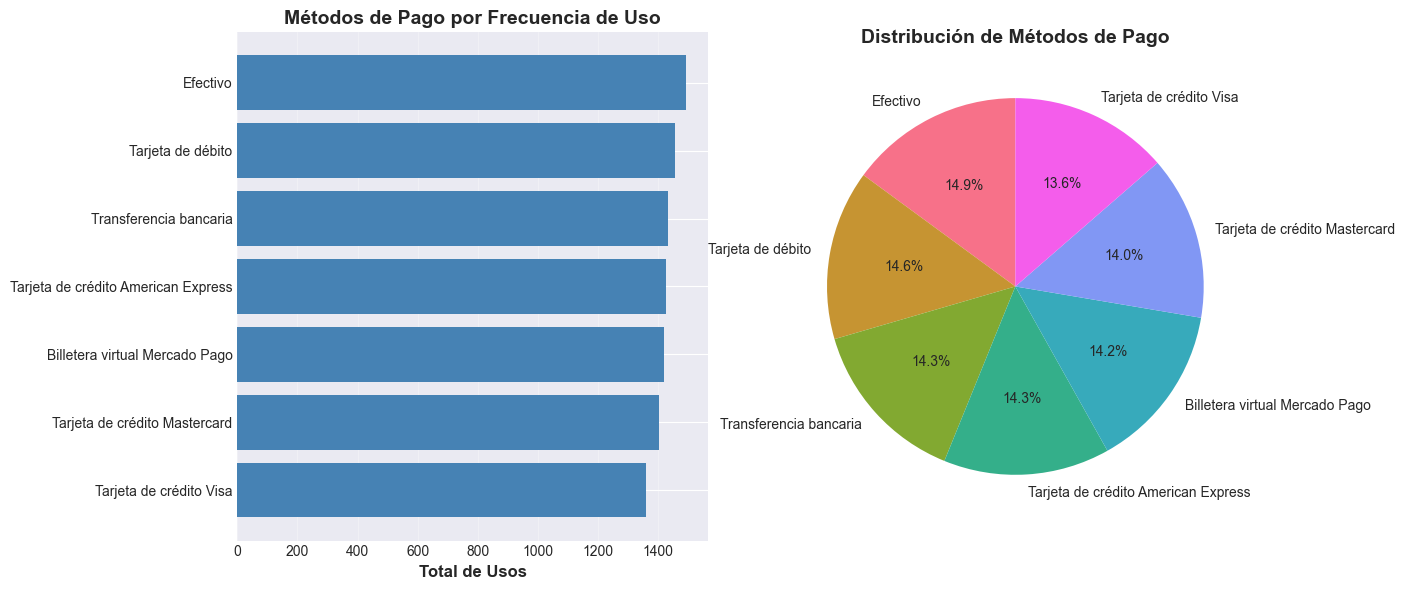


📊 Resumen:
   • Método más utilizado: Efectivo (1493 usos)
   • Total de métodos de pago: 7
   • Total de usos: 10,000


In [11]:
# Consulta SQL para obtener los métodos de pago más utilizados
query_metodos_pago = """
SELECT 
    mp.metodo_pago_id,
    mp.nombre AS metodo_pago,
    mp.descripcion,
    COUNT(omp.orden_metodo_id) AS total_uso,
    COUNT(DISTINCT omp.orden_id) AS total_ordenes,
    SUM(omp.monto_pagado) AS monto_total
FROM metodos_pago mp
LEFT JOIN ordenes_metodos_pago omp ON mp.metodo_pago_id = omp.metodo_pago_id
GROUP BY mp.metodo_pago_id, mp.nombre, mp.descripcion
ORDER BY total_uso DESC;
"""

df_metodos_pago = pd.read_sql(query_metodos_pago, engine)

print("=" * 100)
print("MÉTODOS DE PAGO MÁS UTILIZADOS")
print("=" * 100)
print(df_metodos_pago.to_string(index=False))

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de barras - Uso total
ax1.barh(range(len(df_metodos_pago)), df_metodos_pago['total_uso'], color='steelblue')
ax1.set_yticks(range(len(df_metodos_pago)))
ax1.set_yticklabels(df_metodos_pago['metodo_pago'], fontsize=10)
ax1.set_xlabel('Total de Usos', fontsize=12, fontweight='bold')
ax1.set_title('Métodos de Pago por Frecuencia de Uso', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Gráfico de pastel - Distribución porcentual
colors = sns.color_palette("husl", len(df_metodos_pago))
ax2.pie(df_metodos_pago['total_uso'], labels=df_metodos_pago['metodo_pago'], 
        autopct='%1.1f%%', startangle=90, colors=colors)
ax2.set_title('Distribución de Métodos de Pago', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Método más utilizado: {df_metodos_pago.iloc[0]['metodo_pago']} ({df_metodos_pago.iloc[0]['total_uso']} usos)")
print(f"   • Total de métodos de pago: {len(df_metodos_pago)}")
print(f"   • Total de usos: {df_metodos_pago['total_uso'].sum():,}")


## 2. ¿Cuál es el monto promedio pagado por método de pago?


MONTO PROMEDIO PAGADO POR MÉTODO DE PAGO
 metodo_pago_id                         metodo_pago  total_transacciones  monto_promedio  monto_minimo  monto_maximo  monto_total  desviacion_estandar
              6      Billetera virtual Mercado Pago                 1421          557.59        100.05        999.95    792336.04               263.32
              3 Tarjeta de crédito American Express                 1428          557.42        100.85        999.06    795988.89               264.46
              4                   Tarjeta de débito                 1458          556.18        100.88        999.06    810915.91               261.78
              5              Transferencia bancaria                 1434          551.95        100.28        999.80    791496.47               264.57
              1             Tarjeta de crédito Visa                 1361          547.37        100.96        999.15    744976.33               256.40
              2       Tarjeta de crédito Mastercard  

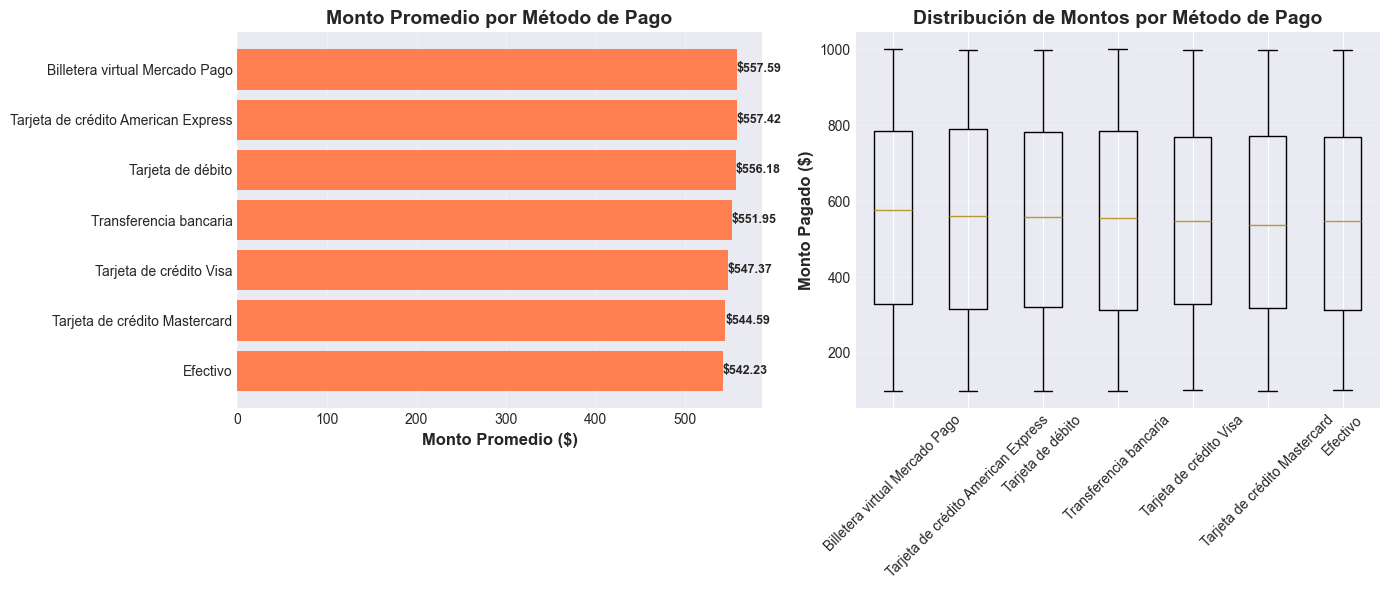


📊 Resumen:
   • Método con mayor monto promedio: Billetera virtual Mercado Pago ($557.59)
   • Método con menor monto promedio: Efectivo ($542.23)
   • Diferencia: $15.36


In [12]:
# Consulta SQL para obtener el monto promedio por método de pago
query_promedio_metodo = """
SELECT 
    mp.metodo_pago_id,
    mp.nombre AS metodo_pago,
    COUNT(omp.orden_metodo_id) AS total_transacciones,
    AVG(omp.monto_pagado) AS monto_promedio,
    MIN(omp.monto_pagado) AS monto_minimo,
    MAX(omp.monto_pagado) AS monto_maximo,
    SUM(omp.monto_pagado) AS monto_total,
    STDDEV(omp.monto_pagado) AS desviacion_estandar
FROM metodos_pago mp
INNER JOIN ordenes_metodos_pago omp ON mp.metodo_pago_id = omp.metodo_pago_id
GROUP BY mp.metodo_pago_id, mp.nombre
ORDER BY monto_promedio DESC;
"""

df_promedio_metodo = pd.read_sql(query_promedio_metodo, engine)

# Formatear columnas numéricas
df_promedio_metodo['monto_promedio'] = df_promedio_metodo['monto_promedio'].round(2)
df_promedio_metodo['monto_minimo'] = df_promedio_metodo['monto_minimo'].round(2)
df_promedio_metodo['monto_maximo'] = df_promedio_metodo['monto_maximo'].round(2)
df_promedio_metodo['monto_total'] = df_promedio_metodo['monto_total'].round(2)
df_promedio_metodo['desviacion_estandar'] = df_promedio_metodo['desviacion_estandar'].round(2)

print("=" * 100)
print("MONTO PROMEDIO PAGADO POR MÉTODO DE PAGO")
print("=" * 100)
print(df_promedio_metodo.to_string(index=False))

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de barras - Monto promedio
ax1.barh(range(len(df_promedio_metodo)), df_promedio_metodo['monto_promedio'], color='coral')
ax1.set_yticks(range(len(df_promedio_metodo)))
ax1.set_yticklabels(df_promedio_metodo['metodo_pago'], fontsize=10)
ax1.set_xlabel('Monto Promedio ($)', fontsize=12, fontweight='bold')
ax1.set_title('Monto Promedio por Método de Pago', fontsize=14, fontweight='bold')
ax1.grid(axis='x', alpha=0.3)
ax1.invert_yaxis()

# Agregar valores en las barras
for i, v in enumerate(df_promedio_metodo['monto_promedio']):
    ax1.text(v, i, f'${v:,.2f}', va='center', fontsize=9, fontweight='bold')

# Gráfico de cajas - Distribución de montos
datos_cajas = []
etiquetas = []
for _, row in df_promedio_metodo.iterrows():
    metodo = row['metodo_pago']
    query_montos = f"""
    SELECT monto_pagado 
    FROM ordenes_metodos_pago omp
    INNER JOIN metodos_pago mp ON omp.metodo_pago_id = mp.metodo_pago_id
    WHERE mp.nombre = '{metodo}'
    """
    montos = pd.read_sql(query_montos, engine)['monto_pagado'].values
    datos_cajas.append(montos)
    etiquetas.append(metodo)

ax2.boxplot(datos_cajas, labels=etiquetas, vert=True)
ax2.set_ylabel('Monto Pagado ($)', fontsize=12, fontweight='bold')
ax2.set_title('Distribución de Montos por Método de Pago', fontsize=14, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Resumen:")
print(f"   • Método con mayor monto promedio: {df_promedio_metodo.iloc[0]['metodo_pago']} (${df_promedio_metodo.iloc[0]['monto_promedio']:,.2f})")
print(f"   • Método con menor monto promedio: {df_promedio_metodo.iloc[-1]['metodo_pago']} (${df_promedio_metodo.iloc[-1]['monto_promedio']:,.2f})")
print(f"   • Diferencia: ${df_promedio_metodo.iloc[0]['monto_promedio'] - df_promedio_metodo.iloc[-1]['monto_promedio']:,.2f}")


## 3. ¿Cuántas órdenes se pagaron usando más de un método de pago?


ÓRDENES CON MÚLTIPLES MÉTODOS DE PAGO

📈 Estadísticas Generales:
   • Total de órdenes: 9,999.0
   • Órdenes con múltiples métodos: 1.0
   • Porcentaje: 0.01%

📋 Detalle de Órdenes con Múltiples Métodos de Pago (Top 20):
 orden_id  cantidad_metodos  monto_total_pagado         fecha_orden  total_orden estado_orden
    10000                 2             1748.39 2024-09-14 09:10:27       204.56    Pendiente


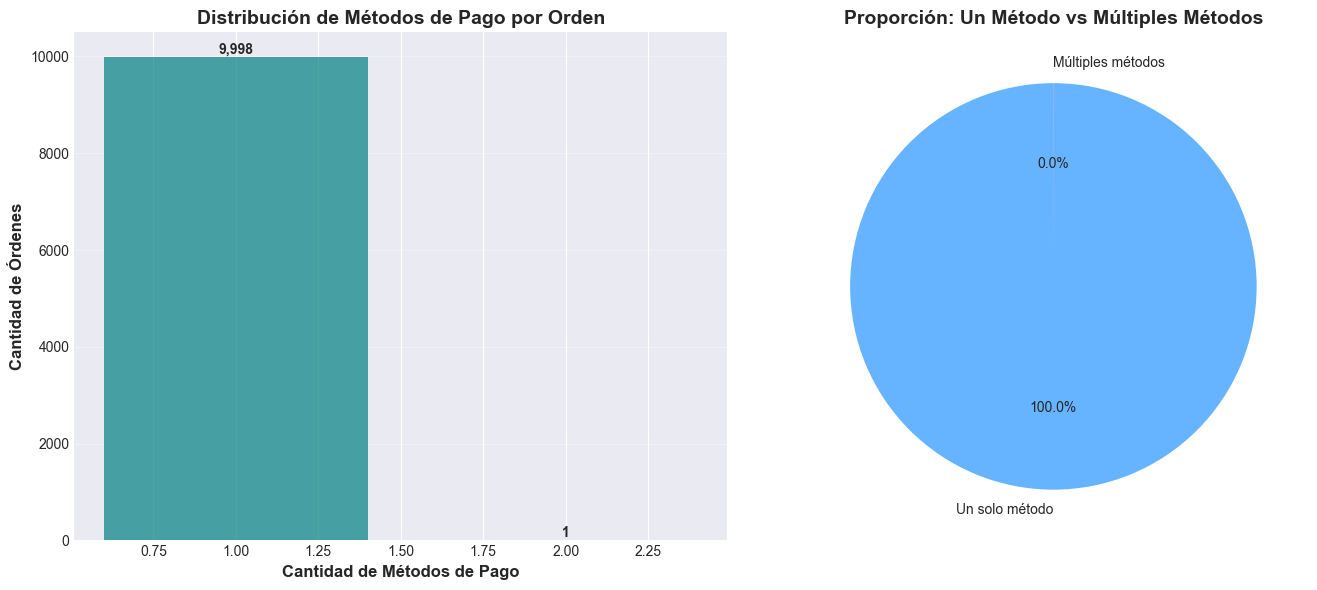


📊 Distribución de Métodos por Orden:
 cantidad_metodos  cantidad_ordenes  monto_total
                1              9998   5508661.57
                2                 1      1748.39


In [13]:
# Consulta SQL para obtener órdenes con múltiples métodos de pago
query_ordenes_multiples = """
WITH ordenes_metodos_count AS (
    SELECT 
        orden_id,
        COUNT(DISTINCT metodo_pago_id) AS cantidad_metodos,
        SUM(monto_pagado) AS monto_total_pagado
    FROM ordenes_metodos_pago
    GROUP BY orden_id
    HAVING COUNT(DISTINCT metodo_pago_id) > 1
)
SELECT 
    omc.orden_id,
    omc.cantidad_metodos,
    omc.monto_total_pagado,
    o.fecha_orden,
    o.total AS total_orden,
    o.estado AS estado_orden
FROM ordenes_metodos_count omc
INNER JOIN ordenes o ON omc.orden_id = o.orden_id
ORDER BY omc.cantidad_metodos DESC, omc.monto_total_pagado DESC;
"""

df_ordenes_multiples = pd.read_sql(query_ordenes_multiples, engine)

# Estadísticas generales
query_estadisticas = """
SELECT 
    COUNT(DISTINCT orden_id) AS total_ordenes,
    COUNT(DISTINCT CASE WHEN cantidad_metodos > 1 THEN orden_id END) AS ordenes_multiples,
    ROUND(
        COUNT(DISTINCT CASE WHEN cantidad_metodos > 1 THEN orden_id END)::NUMERIC / 
        COUNT(DISTINCT orden_id)::NUMERIC * 100, 
        2
    ) AS porcentaje_multiples
FROM (
    SELECT 
        orden_id,
        COUNT(DISTINCT metodo_pago_id) AS cantidad_metodos
    FROM ordenes_metodos_pago
    GROUP BY orden_id
) subquery;
"""

df_estadisticas = pd.read_sql(query_estadisticas, engine)

print("=" * 100)
print("ÓRDENES CON MÚLTIPLES MÉTODOS DE PAGO")
print("=" * 100)
print(f"\n📈 Estadísticas Generales:")
print(f"   • Total de órdenes: {df_estadisticas.iloc[0]['total_ordenes']:,}")
print(f"   • Órdenes con múltiples métodos: {df_estadisticas.iloc[0]['ordenes_multiples']:,}")
print(f"   • Porcentaje: {df_estadisticas.iloc[0]['porcentaje_multiples']}%")

print(f"\n📋 Detalle de Órdenes con Múltiples Métodos de Pago (Top 20):")
print(df_ordenes_multiples.head(20).to_string(index=False))

# Consulta para ver la distribución de cantidad de métodos
query_distribucion = """
SELECT 
    cantidad_metodos,
    COUNT(*) AS cantidad_ordenes,
    SUM(monto_total_pagado) AS monto_total
FROM (
    SELECT 
        orden_id,
        COUNT(DISTINCT metodo_pago_id) AS cantidad_metodos,
        SUM(monto_pagado) AS monto_total_pagado
    FROM ordenes_metodos_pago
    GROUP BY orden_id
) subquery
GROUP BY cantidad_metodos
ORDER BY cantidad_metodos;
"""

df_distribucion = pd.read_sql(query_distribucion, engine)

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de barras - Distribución de métodos por orden
ax1.bar(df_distribucion['cantidad_metodos'], df_distribucion['cantidad_ordenes'], 
        color='teal', alpha=0.7)
ax1.set_xlabel('Cantidad de Métodos de Pago', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cantidad de Órdenes', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Métodos de Pago por Orden', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(df_distribucion['cantidad_ordenes']):
    ax1.text(df_distribucion.iloc[i]['cantidad_metodos'], v, 
             f'{int(v):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico de pastel - Proporción de órdenes con uno vs múltiples métodos
query_pie = """
SELECT 
    CASE 
        WHEN cantidad_metodos = 1 THEN 'Un solo método'
        ELSE 'Múltiples métodos'
    END AS tipo_pago,
    COUNT(*) AS cantidad
FROM (
    SELECT 
        orden_id,
        COUNT(DISTINCT metodo_pago_id) AS cantidad_metodos
    FROM ordenes_metodos_pago
    GROUP BY orden_id
) subquery
GROUP BY tipo_pago;
"""

df_pie = pd.read_sql(query_pie, engine)
colors_pie = ['#66b3ff', '#ff9999']
ax2.pie(df_pie['cantidad'], labels=df_pie['tipo_pago'], 
        autopct='%1.1f%%', startangle=90, colors=colors_pie)
ax2.set_title('Proporción: Un Método vs Múltiples Métodos', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Distribución de Métodos por Orden:")
print(df_distribucion.to_string(index=False))


## 4. ¿Cuántos pagos están en estado 'Procesando' o 'Fallido'?


ESTADO DE PAGOS - ANÁLISIS GENERAL
estado_pago  cantidad_pagos  monto_total  monto_promedio   fecha_mas_antigua  fecha_mas_reciente
    Fallido            2546   1391194.04          546.42 2025-04-01 10:19:16 2025-06-30 10:19:16
 Procesando            2542   1398880.67          550.31 2025-04-01 10:19:16 2025-06-30 10:19:16
     Pagado            2457   1353919.11          551.05 2025-04-01 10:19:16 2025-06-30 10:19:16
Reembolsado            2455   1366211.17          556.50 2025-04-01 10:19:16 2025-06-30 10:19:16

PAGOS EN ESTADO 'PROCESANDO' O 'FALLIDO'
estado_pago  cantidad_pagos  monto_total  monto_promedio   fecha_mas_antigua  fecha_mas_reciente
    Fallido            2546   1391194.04          546.42 2025-04-01 10:19:16 2025-06-30 10:19:16
 Procesando            2542   1398880.67          550.31 2025-04-01 10:19:16 2025-06-30 10:19:16

📊 Resumen de Pagos Problemáticos:
   • Total de pagos 'Procesando': 2,542
   • Total de pagos 'Fallido': 2,546
   • Total de pagos problemáticos: 

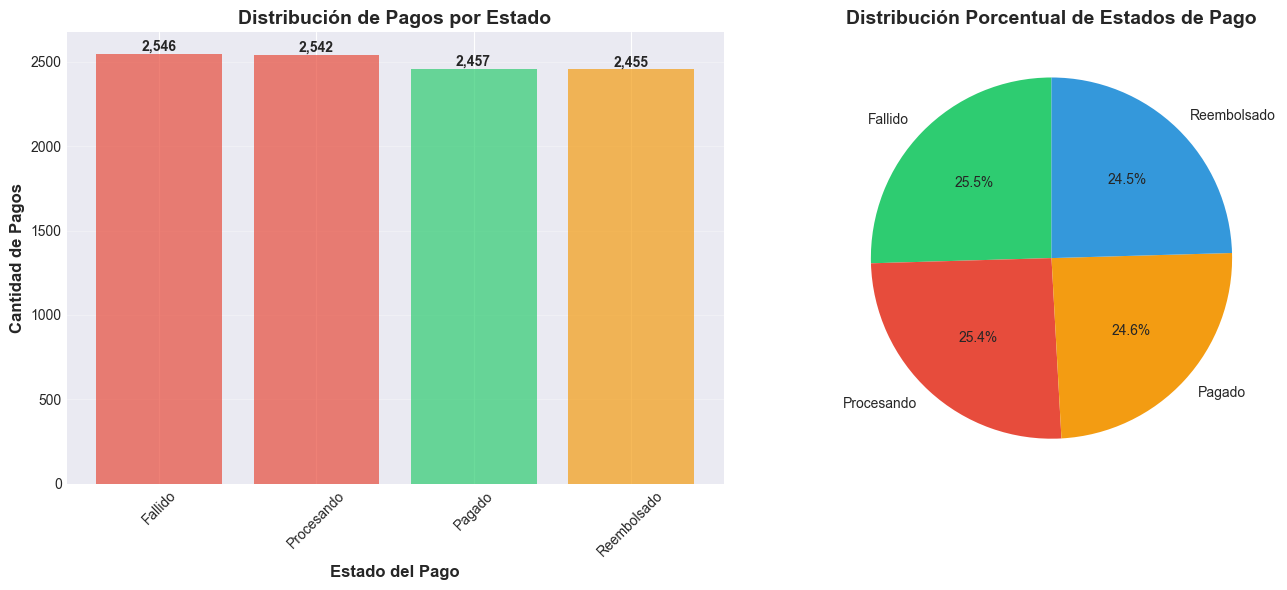


DETALLE DE PAGOS PROBLEMÁTICOS POR MÉTODO DE PAGO
                        metodo_pago estado_pago  cantidad_pagos  monto_total
             Transferencia bancaria  Procesando             388    219853.98
     Billetera virtual Mercado Pago  Procesando             377    211583.65
                           Efectivo  Procesando             363    200180.21
      Tarjeta de crédito Mastercard  Procesando             361    196685.38
Tarjeta de crédito American Express  Procesando             354    190082.07
            Tarjeta de crédito Visa  Procesando             352    191294.39
                  Tarjeta de débito  Procesando             347    189200.99
Tarjeta de crédito American Express     Fallido             393    214129.58
     Billetera virtual Mercado Pago     Fallido             374    209667.66
                           Efectivo     Fallido             371    207470.39
                  Tarjeta de débito     Fallido             368    191694.57
             Transferenci

In [14]:
# Consulta SQL para obtener pagos en estado 'Procesando' o 'Fallido'
query_estados_pago = """
SELECT 
    estado_pago,
    COUNT(*) AS cantidad_pagos,
    SUM(monto) AS monto_total,
    AVG(monto) AS monto_promedio,
    MIN(fecha_pago) AS fecha_mas_antigua,
    MAX(fecha_pago) AS fecha_mas_reciente
FROM historial_pagos
GROUP BY estado_pago
ORDER BY cantidad_pagos DESC;
"""

df_estados_pago = pd.read_sql(query_estados_pago, engine)

# Formatear columnas numéricas
df_estados_pago['monto_total'] = df_estados_pago['monto_total'].round(2)
df_estados_pago['monto_promedio'] = df_estados_pago['monto_promedio'].round(2)

# Filtrar específicamente los estados problemáticos
pagos_procesando_fallido = df_estados_pago[
    df_estados_pago['estado_pago'].isin(['Procesando', 'Fallido'])
]

print("=" * 100)
print("ESTADO DE PAGOS - ANÁLISIS GENERAL")
print("=" * 100)
print(df_estados_pago.to_string(index=False))

print("\n" + "=" * 100)
print("PAGOS EN ESTADO 'PROCESANDO' O 'FALLIDO'")
print("=" * 100)
print(pagos_procesando_fallido.to_string(index=False))

total_procesando_fallido = pagos_procesando_fallido['cantidad_pagos'].sum()
total_pagos = df_estados_pago['cantidad_pagos'].sum()
porcentaje_problema = (total_procesando_fallido / total_pagos * 100) if total_pagos > 0 else 0

print(f"\n📊 Resumen de Pagos Problemáticos:")
print(f"   • Total de pagos 'Procesando': {pagos_procesando_fallido[pagos_procesando_fallido['estado_pago'] == 'Procesando']['cantidad_pagos'].sum() if len(pagos_procesando_fallido[pagos_procesando_fallido['estado_pago'] == 'Procesando']) > 0 else 0:,}")
print(f"   • Total de pagos 'Fallido': {pagos_procesando_fallido[pagos_procesando_fallido['estado_pago'] == 'Fallido']['cantidad_pagos'].sum() if len(pagos_procesando_fallido[pagos_procesando_fallido['estado_pago'] == 'Fallido']) > 0 else 0:,}")
print(f"   • Total de pagos problemáticos: {total_procesando_fallido:,}")
print(f"   • Porcentaje del total: {porcentaje_problema:.2f}%")
print(f"   • Monto total en riesgo: ${pagos_procesando_fallido['monto_total'].sum():,.2f}")

# Visualización
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Gráfico de barras - Cantidad por estado
ax1.bar(df_estados_pago['estado_pago'], df_estados_pago['cantidad_pagos'], 
        color=['#2ecc71' if estado == 'Pagado' else '#e74c3c' if estado in ['Procesando', 'Fallido'] else '#f39c12' 
               for estado in df_estados_pago['estado_pago']],
        alpha=0.7)
ax1.set_xlabel('Estado del Pago', fontsize=12, fontweight='bold')
ax1.set_ylabel('Cantidad de Pagos', fontsize=12, fontweight='bold')
ax1.set_title('Distribución de Pagos por Estado', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(df_estados_pago['cantidad_pagos']):
    ax1.text(i, v, f'{int(v):,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Gráfico de pastel - Distribución porcentual
colors_pie = ['#2ecc71', '#e74c3c', '#f39c12', '#3498db']
ax2.pie(df_estados_pago['cantidad_pagos'], labels=df_estados_pago['estado_pago'], 
        autopct='%1.1f%%', startangle=90, colors=colors_pie[:len(df_estados_pago)])
ax2.set_title('Distribución Porcentual de Estados de Pago', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis detallado de pagos problemáticos por método de pago
if total_procesando_fallido > 0:
    query_detalle_problema = """
    SELECT 
        mp.nombre AS metodo_pago,
        hp.estado_pago,
        COUNT(*) AS cantidad_pagos,
        SUM(hp.monto) AS monto_total
    FROM historial_pagos hp
    INNER JOIN metodos_pago mp ON hp.metodo_pago_id = mp.metodo_pago_id
    WHERE hp.estado_pago IN ('Procesando', 'Fallido')
    GROUP BY mp.nombre, hp.estado_pago
    ORDER BY hp.estado_pago, cantidad_pagos DESC;
    """
    
    df_detalle_problema = pd.read_sql(query_detalle_problema, engine)
    df_detalle_problema['monto_total'] = df_detalle_problema['monto_total'].round(2)
    
    print("\n" + "=" * 100)
    print("DETALLE DE PAGOS PROBLEMÁTICOS POR MÉTODO DE PAGO")
    print("=" * 100)
    print(df_detalle_problema.to_string(index=False))


## 5. ¿Cuál es el monto total recaudado por mes?


MONTO TOTAL RECAUDADO POR MES
    mes_nombre  cantidad_pagos  cantidad_ordenes  monto_total  monto_promedio
April     2025             835               835    469415.61          562.17
May       2025             822               822    441413.46          537.00
June      2025             800               800    443090.04          553.86

📊 Estadísticas Generales:
   • Total recaudado: $1,353,919.11
   • Promedio mensual: $451,306.37
   • Mejor mes: April     2025 ($469,415.61)
   • Peor mes: May       2025 ($441,413.46)
   • Diferencia: $28,002.15


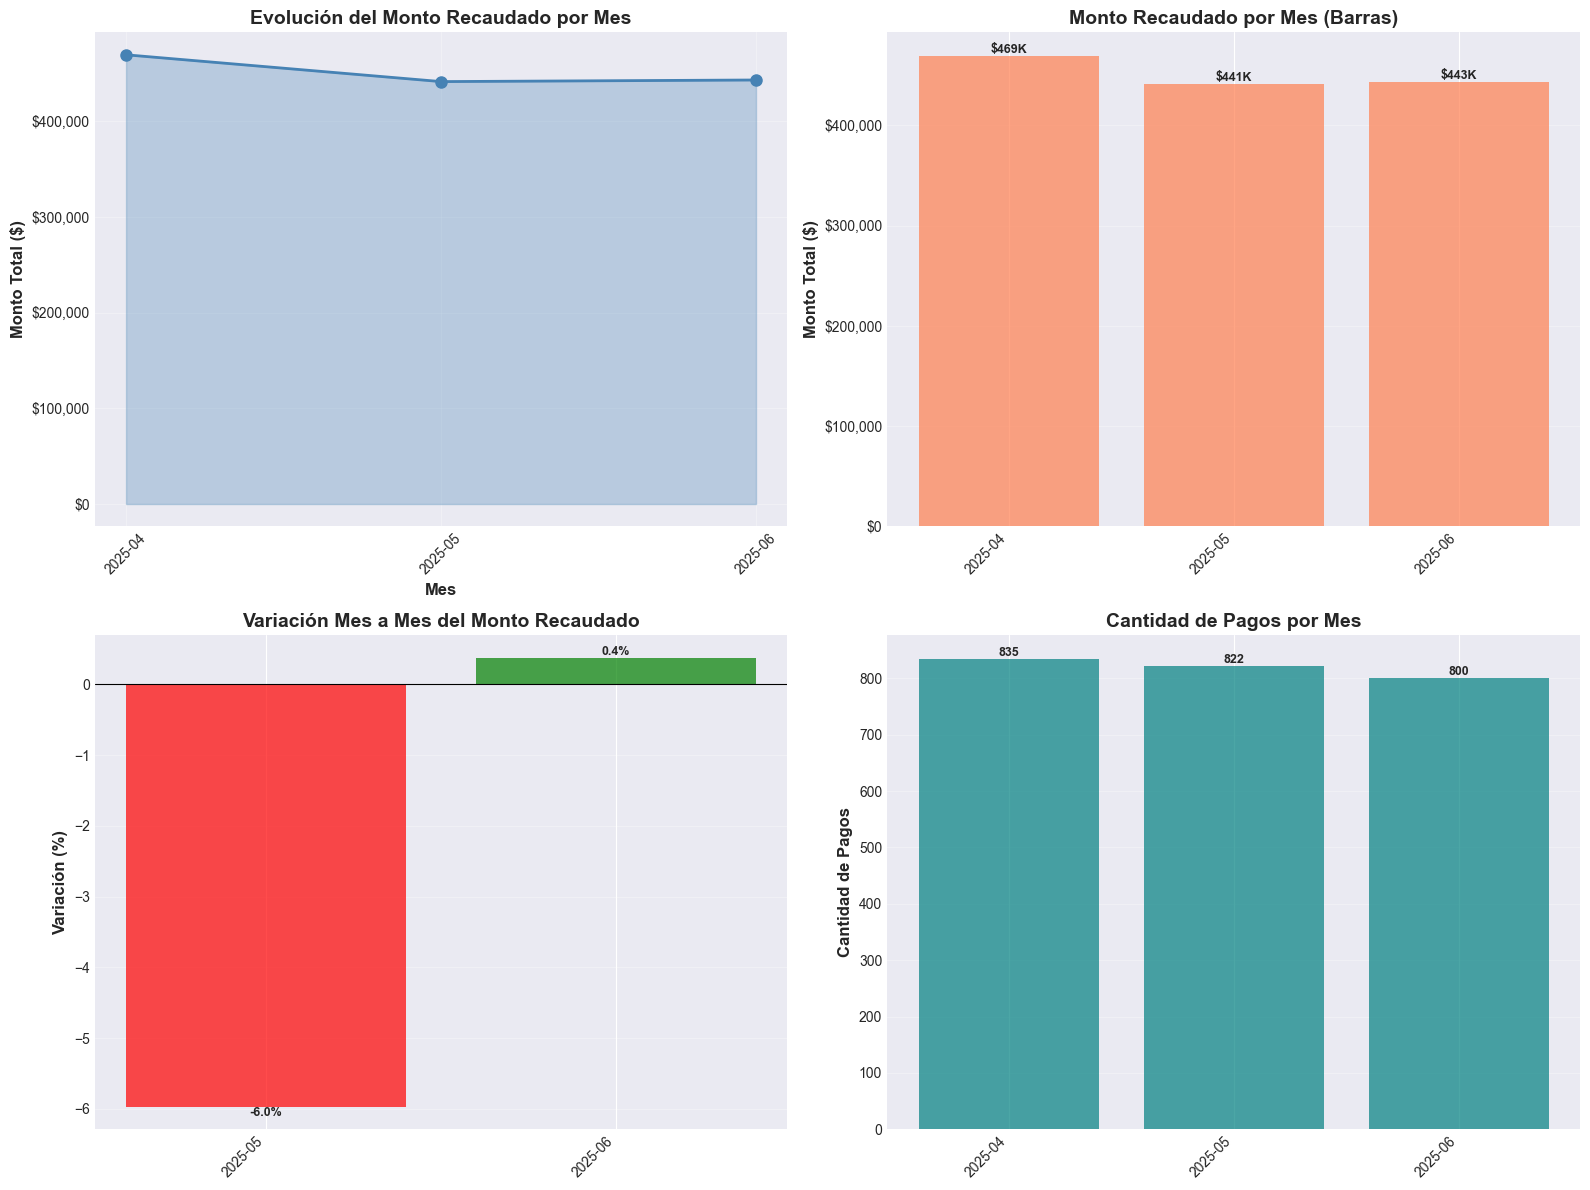


RECAUDACIÓN POR MÉTODO DE PAGO Y MES
       mes mes_formato                         metodo_pago  cantidad_pagos  monto_total
2025-04-01     2025-04              Transferencia bancaria             127     76826.40
2025-04-01     2025-04             Tarjeta de crédito Visa             122     71579.79
2025-04-01     2025-04       Tarjeta de crédito Mastercard             130     70888.94
2025-04-01     2025-04      Billetera virtual Mercado Pago             116     69172.11
2025-04-01     2025-04                   Tarjeta de débito             128     64932.90
2025-04-01     2025-04 Tarjeta de crédito American Express             109     60064.26
2025-04-01     2025-04                            Efectivo             103     55951.21
2025-05-01     2025-05       Tarjeta de crédito Mastercard             130     70839.14
2025-05-01     2025-05             Tarjeta de crédito Visa             125     68672.64
2025-05-01     2025-05 Tarjeta de crédito American Express             127     666

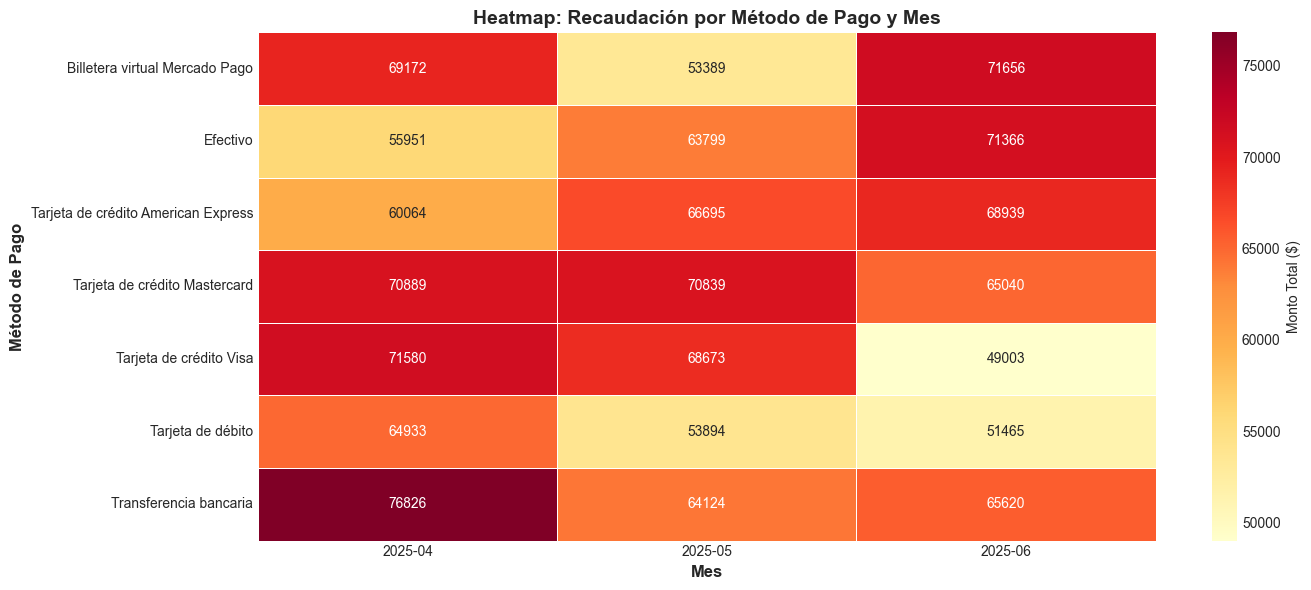

In [15]:
# Consulta SQL para obtener el monto total recaudado por mes
query_recaudacion_mensual = """
SELECT 
    DATE_TRUNC('month', fecha_pago) AS mes,
    TO_CHAR(DATE_TRUNC('month', fecha_pago), 'YYYY-MM') AS mes_formato,
    TO_CHAR(DATE_TRUNC('month', fecha_pago), 'Month YYYY') AS mes_nombre,
    COUNT(*) AS cantidad_pagos,
    COUNT(DISTINCT orden_id) AS cantidad_ordenes,
    SUM(monto) AS monto_total,
    AVG(monto) AS monto_promedio,
    MIN(monto) AS monto_minimo,
    MAX(monto) AS monto_maximo
FROM historial_pagos
WHERE estado_pago = 'Pagado'  -- Solo considerar pagos exitosos
GROUP BY DATE_TRUNC('month', fecha_pago)
ORDER BY mes ASC;
"""

df_recaudacion_mensual = pd.read_sql(query_recaudacion_mensual, engine)

# Formatear columnas numéricas
df_recaudacion_mensual['monto_total'] = df_recaudacion_mensual['monto_total'].round(2)
df_recaudacion_mensual['monto_promedio'] = df_recaudacion_mensual['monto_promedio'].round(2)
df_recaudacion_mensual['monto_minimo'] = df_recaudacion_mensual['monto_minimo'].round(2)
df_recaudacion_mensual['monto_maximo'] = df_recaudacion_mensual['monto_maximo'].round(2)

print("=" * 100)
print("MONTO TOTAL RECAUDADO POR MES")
print("=" * 100)
print(df_recaudacion_mensual[['mes_nombre', 'cantidad_pagos', 'cantidad_ordenes', 
                               'monto_total', 'monto_promedio']].to_string(index=False))

# Calcular estadísticas adicionales
total_general = df_recaudacion_mensual['monto_total'].sum()
promedio_mensual = df_recaudacion_mensual['monto_total'].mean()
mes_maximo = df_recaudacion_mensual.loc[df_recaudacion_mensual['monto_total'].idxmax()]
mes_minimo = df_recaudacion_mensual.loc[df_recaudacion_mensual['monto_total'].idxmin()]

# Calcular variación mes a mes
df_recaudacion_mensual['variacion'] = df_recaudacion_mensual['monto_total'].pct_change() * 100
df_recaudacion_mensual['variacion'] = df_recaudacion_mensual['variacion'].round(2)

print(f"\n📊 Estadísticas Generales:")
print(f"   • Total recaudado: ${total_general:,.2f}")
print(f"   • Promedio mensual: ${promedio_mensual:,.2f}")
print(f"   • Mejor mes: {mes_maximo['mes_nombre']} (${mes_maximo['monto_total']:,.2f})")
print(f"   • Peor mes: {mes_minimo['mes_nombre']} (${mes_minimo['monto_total']:,.2f})")
print(f"   • Diferencia: ${mes_maximo['monto_total'] - mes_minimo['monto_total']:,.2f}")

# Visualización
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico de línea - Evolución mensual
ax1.plot(df_recaudacion_mensual['mes_formato'], df_recaudacion_mensual['monto_total'], 
         marker='o', linewidth=2, markersize=8, color='steelblue')
ax1.fill_between(df_recaudacion_mensual['mes_formato'], df_recaudacion_mensual['monto_total'], 
                  alpha=0.3, color='steelblue')
ax1.set_xlabel('Mes', fontsize=12, fontweight='bold')
ax1.set_ylabel('Monto Total ($)', fontsize=12, fontweight='bold')
ax1.set_title('Evolución del Monto Recaudado por Mes', fontsize=14, fontweight='bold')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Gráfico de barras - Monto por mes
ax2.bar(range(len(df_recaudacion_mensual)), df_recaudacion_mensual['monto_total'], 
        color='coral', alpha=0.7)
ax2.set_xticks(range(len(df_recaudacion_mensual)))
ax2.set_xticklabels(df_recaudacion_mensual['mes_formato'], rotation=45, ha='right')
ax2.set_ylabel('Monto Total ($)', fontsize=12, fontweight='bold')
ax2.set_title('Monto Recaudado por Mes (Barras)', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Agregar valores en las barras
for i, v in enumerate(df_recaudacion_mensual['monto_total']):
    ax2.text(i, v, f'${v/1000:.0f}K', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Gráfico de variación porcentual
variacion_data = df_recaudacion_mensual['variacion'].dropna()
if len(variacion_data) > 0:
    colors_variacion = ['green' if x >= 0 else 'red' for x in variacion_data]
    ax3.bar(range(1, len(variacion_data) + 1), variacion_data, 
            color=colors_variacion, alpha=0.7)
    ax3.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax3.set_xticks(range(1, len(variacion_data) + 1))
    ax3.set_xticklabels(df_recaudacion_mensual['mes_formato'].iloc[1:], rotation=45, ha='right')
    ax3.set_ylabel('Variación (%)', fontsize=12, fontweight='bold')
    ax3.set_title('Variación Mes a Mes del Monto Recaudado', fontsize=14, fontweight='bold')
    ax3.grid(axis='y', alpha=0.3)
    
    # Agregar valores en las barras
    for i, v in enumerate(variacion_data):
        ax3.text(i + 1, v, f'{v:.1f}%', ha='center', 
                va='bottom' if v >= 0 else 'top', fontsize=9, fontweight='bold')

# Gráfico de cantidad de pagos por mes
ax4.bar(range(len(df_recaudacion_mensual)), df_recaudacion_mensual['cantidad_pagos'], 
        color='teal', alpha=0.7)
ax4.set_xticks(range(len(df_recaudacion_mensual)))
ax4.set_xticklabels(df_recaudacion_mensual['mes_formato'], rotation=45, ha='right')
ax4.set_ylabel('Cantidad de Pagos', fontsize=12, fontweight='bold')
ax4.set_title('Cantidad de Pagos por Mes', fontsize=14, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Agregar valores en las barras
for i, v in enumerate(df_recaudacion_mensual['cantidad_pagos']):
    ax4.text(i, v, f'{int(v):,}', ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Análisis por método de pago y mes
query_recaudacion_metodo_mes = """
SELECT 
    DATE_TRUNC('month', hp.fecha_pago) AS mes,
    TO_CHAR(DATE_TRUNC('month', hp.fecha_pago), 'YYYY-MM') AS mes_formato,
    mp.nombre AS metodo_pago,
    COUNT(*) AS cantidad_pagos,
    SUM(hp.monto) AS monto_total
FROM historial_pagos hp
INNER JOIN metodos_pago mp ON hp.metodo_pago_id = mp.metodo_pago_id
WHERE hp.estado_pago = 'Pagado'
GROUP BY DATE_TRUNC('month', hp.fecha_pago), mp.nombre
ORDER BY mes ASC, monto_total DESC;
"""

df_recaudacion_metodo_mes = pd.read_sql(query_recaudacion_metodo_mes, engine)
df_recaudacion_metodo_mes['monto_total'] = df_recaudacion_metodo_mes['monto_total'].round(2)

print("\n" + "=" * 100)
print("RECAUDACIÓN POR MÉTODO DE PAGO Y MES")
print("=" * 100)
print(df_recaudacion_metodo_mes.to_string(index=False))

# Visualización adicional: Heatmap de recaudación por método y mes
if len(df_recaudacion_metodo_mes) > 0:
    pivot_table = df_recaudacion_metodo_mes.pivot_table(
        index='metodo_pago', 
        columns='mes_formato', 
        values='monto_total', 
        fill_value=0
    )
    
    fig, ax = plt.subplots(figsize=(14, 6))
    sns.heatmap(pivot_table, annot=True, fmt='.0f', cmap='YlOrRd', 
                cbar_kws={'label': 'Monto Total ($)'}, ax=ax, linewidths=0.5)
    ax.set_title('Heatmap: Recaudación por Método de Pago y Mes', fontsize=14, fontweight='bold')
    ax.set_xlabel('Mes', fontsize=12, fontweight='bold')
    ax.set_ylabel('Método de Pago', fontsize=12, fontweight='bold')
    plt.tight_layout()
    plt.show()
